# STEPS

## *Steps for Summarization:*
1. Preparing the data
2. Processing the data
3. Tokenizing the article into sentences
4. Finding the similarity between two sentences
5. Rank the sentences according to the simmilarity value
6. Combine the sentences with higher similarity value
7. Get the summary

## *Steps for Headline:*
1. Input data
2. Pre-processing
3. Extract keywords
4. Rank keywords according to the score
5. Combine the keywords using inbuild library to frame a headline
6. Get the headline


## *Steps for Classification:*
1. Data Preprocessing
2. Tokenize the articles into words
3. Lemmatization - combining a word's various inflected forms so that they can be examined as a single object
4. Extracting vectors from text (Vectorization)
5. Predict the category

## *Steps for Webpage:*
The text cells below tell you the steps you need to connect this notebook to Anvil App. The steps are:

1. Install the anvil-uplink library
2. Import the anvil.server package
3. Connect the notebook using your apps Uplink key
4. Create a fuction to call from your app that includes the anvil.server.callable decorator
5. Add anvil.server.wait_forever() to the end of the notebook



# CONNECTING TO DRIVE & IMPORTING LIBRARIES

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive

Mounted at /content/gdrive
MyDrive


In [ ]:
!pip install yake
!pip install keytotext
!pip install rouge_score
!pip install anvil-uplink
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 22.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 8.6 MB/s eta 0:00:

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.0 MB/s eta 0:00:00


In [ ]:
import os
import time
import yake
import glob
import string
import random
import pathlib
import evaluate
import anvil.server
import numpy as np
import pandas as pd
import networkx as nx
from textblob import TextBlob
from keytotext import pipeline
from rouge_score import rouge_scorer

INFO:lightning_fabric.utilities.seed:Global seed set to 42


In [ ]:
import wordcloud
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.cluster.util import cosine_distance
from nltk.tokenize import word_tokenize, sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.exceptions import NotFittedError
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# pip list

# EDA OF BBC NEWS DATASET

In [ ]:
os.listdir('/content/gdrive/MyDrive/News Articles')

['tech', 'business', 'politics', 'entertainment', 'sport']

In [ ]:
articles_path = '/content/gdrive/MyDrive/News Articles'
summaries_path = '/content/gdrive/MyDrive/Summaries'
categories_list = ['politics', 'sport', 'tech', 'entertainment', 'business']

In [ ]:
def read_files_from_folders(articles_path, summaries_path, cateogies_list, encoding='ISO-8859-1'):
    articles = []
    summaries = []
    categories = []
    for category in categories_list:
        article_paths = glob.glob(os.path.join(articles_path, category, '*.txt'), recursive=True)
        summary_paths = glob.glob(os.path.join(summaries_path, category, '*.txt'), recursive=True)

        print(f'found {len(article_paths)} file in articles/{category}, {len(summary_paths)} file in summaries/{category}')

        if len(article_paths) != len(summary_paths):
            print('number of files is not equal')
            return
        for idx_file in range(len(article_paths)):
            categories.append(category)
            with open(article_paths[idx_file], mode = 'r', encoding = encoding) as file:
                articles.append(file.read())

            with open(summary_paths[idx_file], mode = 'r', encoding = encoding ) as file:
                summaries.append(file.read())

    print(f'total {len(articles)} file in articles folders, {len(summaries)} file in summaries folders')
    return articles, summaries, categories

articles, summaries, categories = read_files_from_folders(articles_path, summaries_path, categories_list)

found 417 file in articles/politics, 417 file in summaries/politics
found 511 file in articles/sport, 511 file in summaries/sport
found 401 file in articles/tech, 401 file in summaries/tech
found 386 file in articles/entertainment, 386 file in summaries/entertainment
found 510 file in articles/business, 510 file in summaries/business
total 2225 file in articles folders, 2225 file in summaries folders


In [ ]:
df = pd.DataFrame({'articles': articles,'summaries': summaries, 'categories': categories})
df

,articles,summaries,categories
0,Campbell: E-mail row 'silly fuss'\n\nEx-No 10 ...,Ms Hewitt also announced a new drive to help w...,politics
1,'Errors' doomed first Dome sale\n\nThe initial...,"But Mr Balls, a prospective Labour MP, said he...",politics
2,Watchdog probes e-mail deletions\n\nThe inform...,Mr Howard will host a news conference at the p...,politics
3,Tsunami debt deal to be announced\n\nChancello...,But she said there was a difference between th...,politics
4,Crucial decision on super-casinos\n\nA decisio...,The Labour Party will hold its 2006 autumn con...,politics
...,...,...,...
2220,Trial begins of Spain's top banker\n\nThe tria...,"At the same time, about 100,000 people are exp...",business
2221,Europe asks Asia for euro help\n\nEuropean lea...,Several former HealthSouth employees have alre...,business
2222,World leaders gather to face uncertainty\n\nMo...,"Possibly as a result, the worry about low-cost...",business
2223,Euro firms miss out on optimism\n\nMore than 9...,LVMH said the French designer's haute couture ...,business


In [ ]:
article_headline = []
for i in df['articles']:
    art = i.split('\n\n')
    article_headline.append(art[0])
df['headlines'] = article_headline
df

,articles,summaries,categories,headlines
0,Campbell: E-mail row 'silly fuss'\n\nEx-No 10 ...,Ms Hewitt also announced a new drive to help w...,politics,Campbell: E-mail row 'silly fuss'
1,'Errors' doomed first Dome sale\n\nThe initial...,"But Mr Balls, a prospective Labour MP, said he...",politics,'Errors' doomed first Dome sale
2,Watchdog probes e-mail deletions\n\nThe inform...,Mr Howard will host a news conference at the p...,politics,Watchdog probes e-mail deletions
3,Tsunami debt deal to be announced\n\nChancello...,But she said there was a difference between th...,politics,Tsunami debt deal to be announced
4,Crucial decision on super-casinos\n\nA decisio...,The Labour Party will hold its 2006 autumn con...,politics,Crucial decision on super-casinos
...,...,...,...,...
2220,Trial begins of Spain's top banker\n\nThe tria...,"At the same time, about 100,000 people are exp...",business,Trial begins of Spain's top banker
2221,Europe asks Asia for euro help\n\nEuropean lea...,Several former HealthSouth employees have alre...,business,Europe asks Asia for euro help
2222,World leaders gather to face uncertainty\n\nMo...,"Possibly as a result, the worry about low-cost...",business,World leaders gather to face uncertainty
2223,Euro firms miss out on optimism\n\nMore than 9...,LVMH said the French designer's haute couture ...,business,Euro firms miss out on optimism


In [ ]:
df['articles'] = df['articles'].str.encode('ascii', 'ignore').str.decode('ascii')
df['summaries'] = df['summaries'].str.encode('ascii', 'ignore').str.decode('ascii')
df = df.dropna()

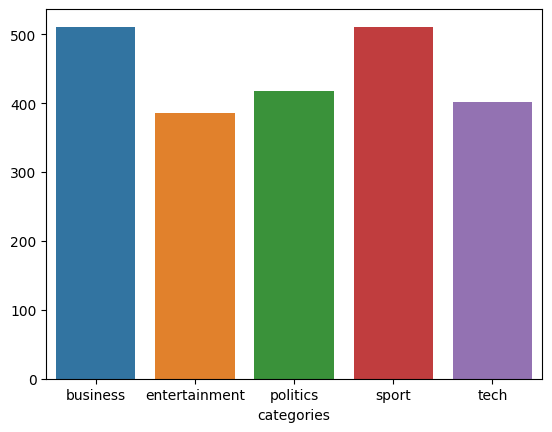

In [ ]:
category_sizes = df.groupby('categories').size()
sns.barplot(x=category_sizes.index, y=category_sizes)
plt.show()

In [ ]:
df['articles_length']=df['articles'].apply(lambda x: len(x.split()))
df['summaries_length']=df['summaries'].apply(lambda x: len(x.split()))
df

,articles,summaries,categories,headlines,articles_length,summaries_length
0,Campbell: E-mail row 'silly fuss'\n\nEx-No 10 ...,Ms Hewitt also announced a new drive to help w...,politics,Campbell: E-mail row 'silly fuss',530,223
1,'Errors' doomed first Dome sale\n\nThe initial...,"But Mr Balls, a prospective Labour MP, said he...",politics,'Errors' doomed first Dome sale,347,275
2,Watchdog probes e-mail deletions\n\nThe inform...,Mr Howard will host a news conference at the p...,politics,Watchdog probes e-mail deletions,379,140
3,Tsunami debt deal to be announced\n\nChancello...,But she said there was a difference between th...,politics,Tsunami debt deal to be announced,170,262
4,Crucial decision on super-casinos\n\nA decisio...,The Labour Party will hold its 2006 autumn con...,politics,Crucial decision on super-casinos,194,104
...,...,...,...,...,...,...
2220,Trial begins of Spain's top banker\n\nThe tria...,"At the same time, about 100,000 people are exp...",business,Trial begins of Spain's top banker,266,259
2221,Europe asks Asia for euro help\n\nEuropean lea...,Several former HealthSouth employees have alre...,business,Europe asks Asia for euro help,189,75
2222,World leaders gather to face uncertainty\n\nMo...,"Possibly as a result, the worry about low-cost...",business,World leaders gather to face uncertainty,707,172
2223,Euro firms miss out on optimism\n\nMore than 9...,LVMH said the French designer's haute couture ...,business,Euro firms miss out on optimism,428,47


In [ ]:
category_length = df.groupby('categories',0).agg( {'articles_length': 'mean', 'summaries_length': 'mean'})
category_length

,articles_length,summaries_length
categories,,
business,328.880392,139.929412
entertainment,330.621762,144.049223
politics,453.973621,195.709832
sport,329.262231,143.187867
tech,502.695761,213.837905


In [ ]:
pd.melt(category_length, ignore_index = True).groupby('variable').mean()

,value
variable,
articles_length,389.086753
summaries_length,167.342848


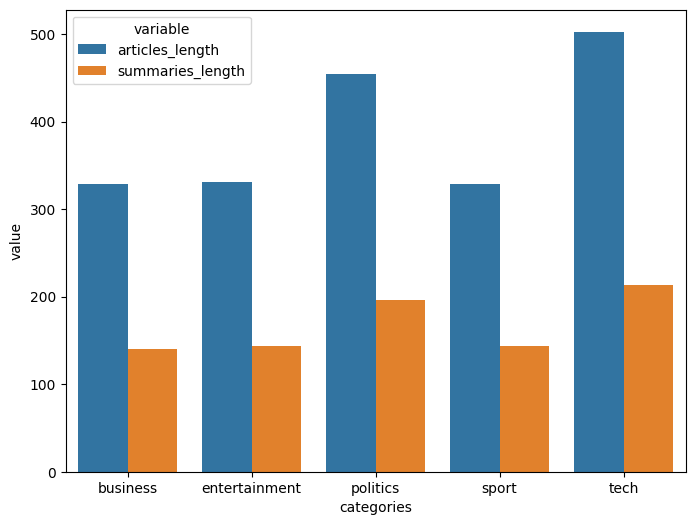

In [ ]:
cateogry_length = df.groupby('categories',0).agg({'articles_length':'mean','summaries_length':'mean'})
df_m = pd.melt(category_length, ignore_index = False)
plt.figure(figsize = (8,6))
sns.barplot(x=df_m.index, y='value', hue='variable', data = df_m)
plt.show()

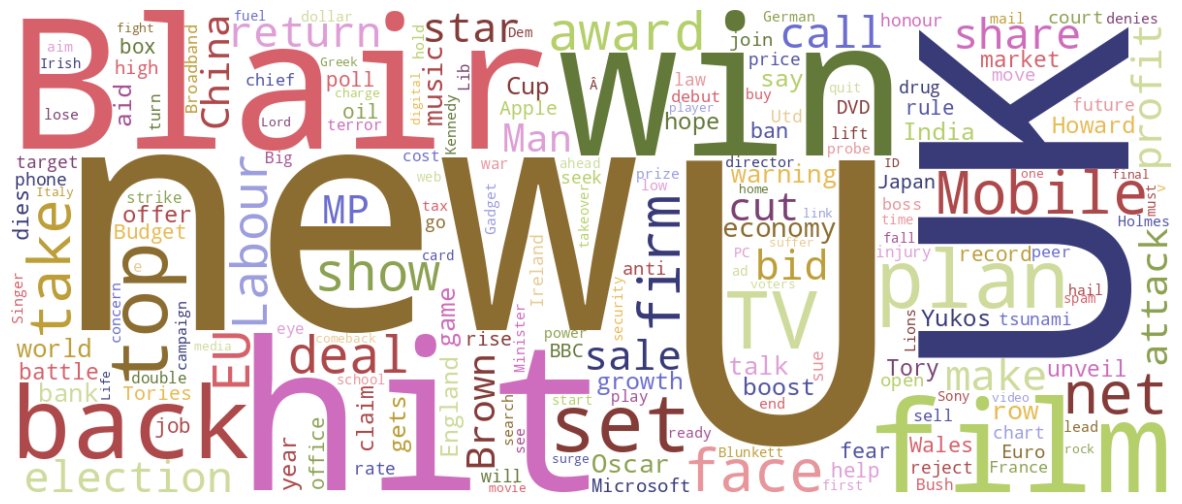

In [ ]:
wc = wordcloud.WordCloud(width=1200, height=500,
                         collocations=False, background_color="white",
                         colormap="tab20b").generate(" ".join(df['headlines']))
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

# SPLITTING INTO TRAINING AND TESTING

In [ ]:
df_sample = df.sample(n = 150, random_state = 42)

In [ ]:
train_df, test_df = train_test_split(df_sample, test_size = 0.2, random_state = 0, stratify = df_sample[['categories']])

In [ ]:
training = train_df[['articles','summaries','categories','headlines']]
training

,articles,summaries,categories,headlines
2118,Delta cuts fares in survival plan\n\nDelta Air...,With winter temperatures staying relatively hi...,business,Delta cuts fares in survival plan
544,Chelsea denied by James heroics\n\nA brave def...,"Switzerland, Ireland, France and Israel are al...",sport,Chelsea denied by James heroics
100,New drink limit 'would cut toll'\n\nMore lives...,A total of 53% of those polled said they had s...,politics,New drink limit 'would cut toll'
2044,Troubled Marsh under SEC scrutiny\n\nThe US st...,The value of trade in April-July rose to $186....,business,Troubled Marsh under SEC scrutiny
941,Virus poses as Christmas e-mail\n\nSecurity fi...,The UK Film Council has awarded a contract wor...,tech,Virus poses as Christmas e-mail
...,...,...,...,...
1746,Rich grab half Colombia poor fund\n\nHalf of t...,Leisure group Rank could unveil plans to demer...,business,Rich grab half Colombia poor fund
1876,US data sparks inflation worries\n\nWholesale ...,Russian media reported that India and Russia s...,business,US data sparks inflation worries
1040,Viewers to be able to shape TV\n\nImagine edit...,"But currently, putting a master feature film o...",tech,Viewers to be able to shape TV
247,Donor attacks Blair-Brown 'feud'\n\nThe report...,Lord Haskins even suggested Mr Blair should re...,politics,Donor attacks Blair-Brown 'feud'


In [ ]:
testing = test_df[['articles']]
testing

,articles
297,Hague 'given up' his PM ambition\n\nFormer Con...
1232,IBM puts cash behind Linux push\n\nIBM is spen...
307,Talks aim to avert pension strike\n\nTalks aim...
1582,Soul sensation ready for awards\n\nSouth West ...
845,Venus stunned by Farina Elia\n\nVenus Williams...
1204,Souped-up wi-fi is on the horizon\n\nSuper hig...
677,Bellamy fined after row\n\nNewcastle have fine...
18,E-University 'disgraceful waste'\n\nA failed g...
350,Lib Dems target first-time buyers\n\nThe Liber...
426,Kenya lift Chepkemei's suspension\n\nKenya's a...


# TEXT SUMMARIZATION

In [ ]:
class TextSummary:
    def __init__(self, data):
        self.data = data


    # Converting paragraph into sentence
    def _read_article(self):
        paragraph =[]
        paragraph = sent_tokenize(self.data)
        for para in paragraph:
            para.replace("[^a-zA-Z0-9]"," ")
        return paragraph


    # Removing headline
    def _article(self):
        paragraph = self._read_article()
        paragraph[0] = ''.join(paragraph[0].split('\n\n')[1:])
        return paragraph


    # Spell correction
    def _spell_correction(self):
        text_list = self._article()
        mod_sent = []
        for txt in text_list:
            blob_obj = TextBlob(txt)
            correct_sent = str(blob_obj.correct())
            mod_sent.append(correct_sent)
        new_text = " ".join(mod_sent)
        return new_text


    # Corrected sentence tokenization
    def _sentence_token(self):
        new_para = self._spell_correction()
        sentences = sent_tokenize(new_para)
        return sentences

In [ ]:
def read_article(article):
    fd = TextSummary(article)
    filedata = fd._spell_correction()
    article = filedata.split(". ")
    sentences = []
    for sentence in article:
        sentences.append(sentence.replace("[^a-zA-Z]", " ").split(" "))
    sentences.pop()
    return sentences


def sentence_similarity(sent1, sent2, stopwords=None):
    if stopwords is None:
        stopwords = []
    sent1 = [w.lower() for w in sent1]
    sent2 = [w.lower() for w in sent2]
    all_words = list(set(sent1 + sent2))
    vector1 = [0] * len(all_words)
    vector2 = [0] * len(all_words)
    # build the vector for the first sentence
    for w in sent1:
        if w in stopwords:
            continue
        vector1[all_words.index(w)] += 1
    # build the vector for the second sentence
    for w in sent2:
        if w in stopwords:
            continue
        vector2[all_words.index(w)] += 1
    return 1 - cosine_distance(vector1, vector2)


def build_similarity_matrix(sentences, stop_words):
    # Create an empty similarity matrix
    similarity_matrix = np.zeros((len(sentences), len(sentences)))
    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2], stop_words)
    return similarity_matrix


def generate_summary(file_name, top_n):
    stop_words = stopwords.words('english')
    summarize_text = []
    # Step 1 - Read text anc split it
    sentences =  read_article(file_name)
    # Step 2 - Generate Similary Martix across sentences
    sentence_similarity_martix = build_similarity_matrix(sentences, stop_words)
    # Step 3 - Rank sentences in similarity martix
    sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)
    scores = nx.pagerank(sentence_similarity_graph)
    # Step 4 - Sort the rank and pick top sentences
    ranked_sentence = sorted(((scores[i],s) for i,s in enumerate(sentences)), reverse=True)
    # print("Indexes of top ranked_sentence order are ", ranked_sentence)
    for i in range(top_n):
      summarize_text.append(" ".join(ranked_sentence[i][1]))
    # Step 5 - Offcourse, output the summarize text
    summary = ". ".join(summarize_text)
    return summary

# HEADLINE GENERATION

In [ ]:
class TextHeadline:
    def __init__(self,doc):
        self.doc = doc


    # Extracting keywords from the article
    def _keywords(self):
        kw_extractor = yake.KeywordExtractor()
        keywords = kw_extractor.extract_keywords(self.doc)
        keys = []
        key_word = []
        for i in keywords:
            if i[1] > 0.1:
                keys.append(i)
        for kw in keys:
            key_word.append(kw[0])
        return key_word

    # Converting the keywords into sentence or headline
    def _keyword2text(self):
        list_key_word = self._keywords()
        nlp = pipeline("k2t-base")  #loading the pre-trained model
        params = {"do_sample":False, "num_beams":1, "no_repeat_ngram_size":0 , "early_stopping":False}    #decoding params
        headline = nlp(list_key_word, **params)  #keywords
        return headline

# TEXT CLASSIFICATION


In [ ]:
def clean_text(text):
    # Convert the text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize the text into words
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if not word in stop_words]
    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join the tokens back into a single string
    text = ' '.join(tokens)
    return text

# Preprocess the news article column
training['cleaned_text'] = training['articles'].apply(clean_text)
training

<ipython-input-26-f3ebdcd89349>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training['cleaned_text'] = training['articles'].apply(clean_text)


,articles,summaries,categories,headlines,cleaned_text
2118,Delta cuts fares in survival plan\n\nDelta Air...,With winter temperatures staying relatively hi...,business,Delta cuts fares in survival plan,delta cut fare survival plan delta air line cu...
544,Chelsea denied by James heroics\n\nA brave def...,"Switzerland, Ireland, France and Israel are al...",sport,Chelsea denied by James heroics,chelsea denied james heroic brave defensive di...
100,New drink limit 'would cut toll'\n\nMore lives...,A total of 53% of those polled said they had s...,politics,New drink limit 'would cut toll',new drink limit would cut toll life previously...
2044,Troubled Marsh under SEC scrutiny\n\nThe US st...,The value of trade in April-July rose to $186....,business,Troubled Marsh under SEC scrutiny,troubled marsh sec scrutiny u stock market reg...
941,Virus poses as Christmas e-mail\n\nSecurity fi...,The UK Film Council has awarded a contract wor...,tech,Virus poses as Christmas e-mail,virus pose christmas email security firm warni...
...,...,...,...,...,...
1746,Rich grab half Colombia poor fund\n\nHalf of t...,Leisure group Rank could unveil plans to demer...,business,Rich grab half Colombia poor fund,rich grab half colombia poor fund half money p...
1876,US data sparks inflation worries\n\nWholesale ...,Russian media reported that India and Russia s...,business,US data sparks inflation worries,u data spark inflation worry wholesale price u...
1040,Viewers to be able to shape TV\n\nImagine edit...,"But currently, putting a master feature film o...",tech,Viewers to be able to shape TV,viewer able shape tv imagine editing titanic w...
247,Donor attacks Blair-Brown 'feud'\n\nThe report...,Lord Haskins even suggested Mr Blair should re...,politics,Donor attacks Blair-Brown 'feud',donor attack blairbrown feud reported feud ton...


In [ ]:
class TextCategory:
    def __init__(self, text, training):
        self.text = text
        self.training = training
        self.vectorizer = self._vectorizer()


    # Define a function to preprocess and clean the text data
    def _clean_text(self):
        text = self.text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if not word in stop_words]
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
        text = ' '.join(tokens)
        return text


    # Create a TfidfVectorizer to convert the text data into numerical vectors
    def _vectorizer(self):
        vectorizer = TfidfVectorizer()
        # Fit the vectorizer to the cleaned text column
        vectorizer.fit(self.training['cleaned_text'])
        return vectorizer


    # Transform the cleaned text column into a numerical vector representation
    def _clf(self):
        X = self.vectorizer.transform(self.training['cleaned_text'])
        y = self.training['categories']
        clf = MultinomialNB()
        clf.fit(X, y)
        return clf


    # Define a function to predict the category of a new news article
    def _predict_category(self):
        self.clf = self._clf()
        article_vector = self.vectorizer.transform([self._clean_text()])
        return self.clf.predict(article_vector)[0]

# TESTING

In [ ]:
data = testing

In [ ]:
# Summarization
summaries = []
for d in data['articles']:
    summary = TextSummary(d)
    sent_tok = summary._sentence_token()
    spell_corr = summary._spell_correction()
    lent = int(np.round((len(sent_tok))/2))
    sum = generate_summary(spell_corr,lent)
    summaries.append(sum)
testing['new_summaries'] = summaries

<ipython-input-29-e2a4b6e802b9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing['new_summaries'] = summaries


In [ ]:
# Headline
headlines = []
for d in data['articles']:
    headline = TextHeadline(d)
    head = headline._keyword2text()
    headlines.append(head)
testing['new_headlines'] = headlines

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1260: UserWarning: Using the model-agnostic default `max_length` (=20) to control thegeneration length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
<ipython-input-30-0ebde52dfa1b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing['new_headlines'] = headlines


In [ ]:
# Classification
categories = []
for d in data['articles']:
    category = TextCategory(d,training)
    cat = category._predict_category()
    categories.append(cat)
testing['new_categories'] = categories

<ipython-input-31-8943a2ec0682>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing['new_categories'] = categories


# ACCURACY

In [ ]:
hyp_sum = test_df['summaries'].values.tolist()
ref_sum = testing['new_summaries'].values.tolist()
hyp_head = test_df['headlines'].values.tolist()
ref_head = testing['new_headlines'].values.tolist()

In [ ]:
scorer_1 = rouge_scorer.RougeScorer(['rouge1'])

In [ ]:
scorer_2 = rouge_scorer.RougeScorer(['rouge2'])

In [ ]:
scorer_L = rouge_scorer.RougeScorer(['rougeL'])

In [ ]:
def rouge_1(hyp, ref):
    # a dictionary that will contain the results
    scores = []
    results = {'precision': [], 'recall': [], 'fmeasure': []}
    # for each of the hypothesis and reference documents pair
    for (h, r) in zip(hyp, ref):
        # computing the ROUGE
        score = scorer_1.score(h, r)
        # separating the measurements
        precision, recall, fmeasure = score['rouge1']
        # add them to the proper list in the dictionary
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['fmeasure'].append(fmeasure)
    res = list(results.values())
    scores.append(res[-1][0])
    return scores

In [ ]:
def rouge_2(hyp, ref):
    # a dictionary that will contain the results
    scores = []
    results = {'precision': [], 'recall': [], 'fmeasure': []}
    # for each of the hypothesis and reference documents pair
    for (h, r) in zip(hyp, ref):
        # computing the ROUGE
        score = scorer_2.score(h, r)
        # separating the measurements
        precision, recall, fmeasure = score['rouge2']
        # add them to the proper list in the dictionary
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['fmeasure'].append(fmeasure)
    res = list(results.values())
    scores.append(res[-1][0])
    return scores

In [ ]:
def rouge_L(hyp, ref):
    # a dictionary that will contain the results
    scores = []
    results = {'precision': [], 'recall': [], 'fmeasure': []}
    # for each of the hypothesis and reference documents pair
    for (h, r) in zip(hyp, ref):
        # computing the ROUGE
        score = scorer_L.score(h, r)
        # separating the measurements
        precision, recall, fmeasure = score['rougeL']
        # add them to the proper list in the dictionary
        results['precision'].append(precision)
        results['recall'].append(recall)
        results['fmeasure'].append(fmeasure)
    res = list(results.values())
    scores.append(res[-1][0])
    return scores

In [ ]:
# Summarization
accuracy_sum_1 = []
accuracy_sum_2 = []
accuracy_sum_L = []
as1 = 0
as2 = 0
asL = 0
for i in range(len(testing)):
    hyp_1 = []
    ref_1 = []
    hyp_1.append(hyp_sum[i])
    ref_1.append(ref_sum[i])
    # Rouge1 score
    acc_sum_1 = rouge_1(hyp_1,ref_1)
    accuracy_sum_1.append(acc_sum_1)
    as1 = as1 + accuracy_sum_1[i][0]
    # Rouge2 score
    acc_sum_2 = rouge_2(hyp_1,ref_1)
    accuracy_sum_2.append(acc_sum_2)
    as2 = as2 + accuracy_sum_2[i][0]
    # RougeL score
    acc_sum_L = rouge_L(hyp_1,ref_1)
    accuracy_sum_L.append(acc_sum_L)
    asL = asL + accuracy_sum_L[i][0]

accuracy_summary_1 = round(((as1 / len(accuracy_sum_1)) * 100), 2)
accuracy_summary_2 = round(((as2 / len(accuracy_sum_2)) * 100), 2)
accuracy_summary_L = round(((asL / len(accuracy_sum_L)) * 100), 2)

In [ ]:
# Headline
accuracy_head_1 = []
accuracy_head_2 = []
accuracy_head_L = []
ah1 = 0
ah2 = 0
ahL = 0
for i in range(len(testing)):
    hyp_2 = []
    ref_2 = []
    hyp_2.append(hyp_sum[i])
    ref_2.append(ref_sum[i])
    # Rouge1 socre
    acc_head_1 = rouge_1(hyp_2,ref_2)
    accuracy_head_1.append(acc_head_1)
    ah1 = ah1 + accuracy_head_1[i][0]
    # Rouge2 score
    acc_head_2 = rouge_2(hyp_2,ref_2)
    accuracy_head_2.append(acc_head_2)
    ah2 = ah2 + accuracy_head_2[i][0]
    # RougeL score
    acc_head_L = rouge_L(hyp_2,ref_2)
    accuracy_head_L.append(acc_head_L)
    ahL = ahL + accuracy_head_L[i][0]

accuracy_headline_1 = round(((ah1 / len(accuracy_head_1)) * 100), 2)
accuracy_headline_2 = round(((ah2 / len(accuracy_head_2)) * 100), 2)
accuracy_headline_L = round(((ahL / len(accuracy_head_L)) * 100), 2)

In [ ]:
correct_predictions = 0
for i in range(len(testing)):
    if categories[i] == test_df.iloc[i]['categories']:
        correct_predictions += 1

accuracy_category = round(((correct_predictions / len(testing)) * 100), 2)

In [ ]:
print(classification_report(test_df[['categories']], testing[['new_categories']]))

               precision    recall  f1-score   support

     business       1.00      0.50      0.67         6
entertainment       1.00      0.25      0.40         4
     politics       0.64      1.00      0.78         7
        sport       0.80      1.00      0.89         8
         tech       1.00      1.00      1.00         5

     accuracy                           0.80        30
    macro avg       0.89      0.75      0.75        30
 weighted avg       0.86      0.80      0.77        30



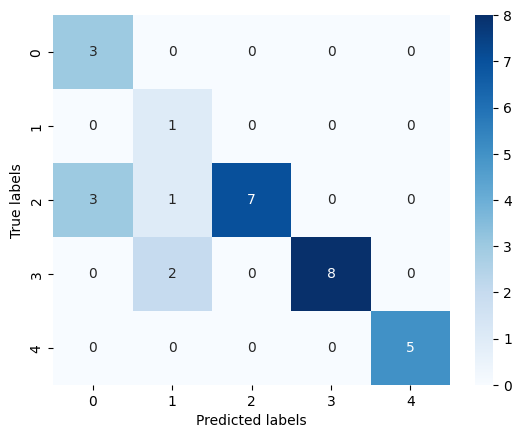

In [ ]:
cm_nb = confusion_matrix(testing[['new_categories']],test_df[['categories']])
sns.heatmap(cm_nb, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# ACCURACY FOR SUMMARY AND HEADLINE

In [ ]:
# Original Article
file_path = '/content/gdrive/MyDrive/NewArticles_Files/business/046.txt'
with open(file_path, "r") as f:
    article1 = f.read()

# Original Summary
file_path = '/content/gdrive/MyDrive/Summaries_Files/business/046.txt'
with open(file_path, "r") as f:
    summary1 = f.read()

# Original Headline
head1 = article1.split('\n\n')
headline1 = head1[0]

# Summarization
summary = TextSummary(article1)
sent_tok = summary._sentence_token()
spell_corr = summary._spell_correction()
lent = int(np.round((len(sent_tok))/2))
sum = generate_summary(spell_corr,lent)

# Headline
headline = TextHeadline(article1)
head = headline._keyword2text()

In [ ]:
# Accuracy of Summarization
hyp_art_1 = []
ref_art_1 = []
hyp_art_1.append(sum)
ref_art_1.append(summary1)
# Rouge1 score
acc_art_sum_1 = rouge_1(hyp_art_1,ref_art_1)
accuracy_art_summary_1 = round((acc_art_sum_1[0] * 100), 2)
# Rouge2 score
acc_art_sum_2 = rouge_2(hyp_art_1,ref_art_1)
accuracy_art_summary_2 = round((acc_art_sum_2[0] * 100), 2)
# RougeL score
acc_art_sum_L = rouge_L(hyp_art_1,ref_art_1)
accuracy_art_summary_L = round((acc_art_sum_L[0] * 100), 2)


# Accuracy of Hradline
hyp_art_2 = []
ref_art_2 = []
hyp_art_2.append(head)
ref_art_2.append(headline1)
# Rouge1 score
acc_art_head_1 = rouge_1(hyp_art_2,ref_art_2)
accuracy_art_headline_1 = round((acc_art_head_1[0] * 100), 2)
# Rouge2 score
acc_art_head_2 = rouge_2(hyp_art_2,ref_art_2)
accuracy_art_headline_2 = round((acc_art_head_2[0] * 100), 2)
# RougeL score
acc_art_head_L = rouge_L(hyp_art_2,ref_art_2)
accuracy_art_headline_L = round((acc_art_head_L[0] * 100), 2)

In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

In [ ]:
candidate_summary = sum
reference_summaries = []
reference_summaries.append(summary1)
scores = {key: [] for key in ['rouge1', 'rouge2', 'rougeL']}
for ref in reference_summaries:
    temp_scores = scorer.score(ref, candidate_summary)
    for key in temp_scores:
        scores[key].append(temp_scores[key])

for key in scores:
    print(f'{key}:\n{scores[key]}')

rouge1:
[Score(precision=0.6971830985915493, recall=0.853448275862069, fmeasure=0.7674418604651163)]
rouge2:
[Score(precision=0.624113475177305, recall=0.7652173913043478, fmeasure=0.6875)]
rougeL:
[Score(precision=0.5633802816901409, recall=0.6896551724137931, fmeasure=0.6201550387596899)]


# ACCURACY FOR SUMMARY

In [ ]:
os.listdir('/content/gdrive/MyDrive/NewArticles_Files')

['business', 'sport', 'politics', 'entertainment', 'tech']

In [ ]:
articles_path_sum = '/content/gdrive/MyDrive/NewArticles_Files'
summaries_path_sum = '/content/gdrive/MyDrive/Summaries_Files'
categories_list_sum = ['politics', 'sport', 'tech', 'entertainment', 'business']

In [ ]:
def read_files_from_folders(articles_path, summaries_path, cateogies_list, encoding='ISO-8859-1'):
    articles = []
    summaries = []
    categories = []
    for category in categories_list:
        article_paths = glob.glob(os.path.join(articles_path, category, '*.txt'), recursive=True)
        summary_paths = glob.glob(os.path.join(summaries_path, category, '*.txt'), recursive=True)

        print(f'found {len(article_paths)} file in articles/{category}, {len(summary_paths)} file in summaries/{category}')

        if len(article_paths) != len(summary_paths):
            print('number of files is not equal')
            return
        for idx_file in range(len(article_paths)):
            categories.append(category)
            with open(article_paths[idx_file], mode = 'r', encoding = encoding) as file:
                articles.append(file.read())

            with open(summary_paths[idx_file], mode = 'r', encoding = encoding ) as file:
                summaries.append(file.read())

    print(f'total {len(articles)} file in articles folders, {len(summaries)} file in summaries folders')
    return articles, summaries, categories

articles_sum, summaries_sum, categories_sum = read_files_from_folders(articles_path_sum, summaries_path_sum, categories_list_sum)

found 6 file in articles/politics, 6 file in summaries/politics
found 6 file in articles/sport, 6 file in summaries/sport
found 6 file in articles/tech, 6 file in summaries/tech
found 6 file in articles/entertainment, 6 file in summaries/entertainment
found 6 file in articles/business, 6 file in summaries/business
total 30 file in articles folders, 30 file in summaries folders


In [ ]:
df_summary = pd.DataFrame({'articles': articles_sum,'summaries': summaries_sum, 'categories': categories_sum})
df_summary

,articles,summaries,categories
0,Ministers deny care sums 'wrong'\n\nMinisters ...,Ministers have insisted they are committed to ...,politics
1,End Bush 'denial' Blair tells EU\n\nTony Blair...,Mr Blair has probably been closer to President...,politics
2,Police chief backs drinking move\n\nA chief co...,The Metropolitan police chief said last week t...,politics
3,Immigration to be election issue\n\nImmigratio...,Immigration and asylum have normally been issu...,politics
4,"Prime minister's questions\n\nSo who, if anyon...",The prime minister claims this is the clearest...,politics
5,Terror suspects face house arrest\n\nUK citize...,British citizens are being included in the cha...,politics
6,Wenger shock at Newcastle dip\n\nArsenal manag...,Arsenal go into the game on the back of a 2-0 ...,sport
7,Parker misses England clash\n\nTom Shanklin wi...,Ruddock says the players will benefit from the...,sport
8,Wales stars need a rest - Ruddock\n\nWales coa...,England coach Andy Robinson faces the first ma...,sport
9,Robinson ready for difficult task\n\nEngland c...,G Thomas (Toulouse (capt); H Luscombe (Dragons...,sport


In [ ]:
df_summary['articles'] = df_summary['articles'].str.encode('ascii', 'ignore').str.decode('ascii')
df_summary['summaries'] = df_summary['summaries'].str.encode('ascii', 'ignore').str.decode('ascii')
df_summary = df_summary.dropna()

In [ ]:
data_sum = df_summary[['articles']]

In [ ]:
# Summarization
new_summaries = []
for d in data_sum['articles']:
    summary = TextSummary(d)
    sent_tok = summary._sentence_token()
    spell_corr = summary._spell_correction()
    lent = int(np.round((len(sent_tok))/2))
    sum = generate_summary(spell_corr,lent)
    new_summaries.append(sum)
df_summary['new_summaries'] = new_summaries

In [ ]:
hyp_sum_new = df_summary['summaries'].values.tolist()
ref_sum_new = df_summary['new_summaries'].values.tolist()

In [ ]:
# Summarization
new_accuracy_sum_1 = []
new_accuracy_sum_2 = []
new_accuracy_sum_L = []
as_1 = 0
as_2 = 0
as_L = 0
for i in range(len(df_summary)):
    hyp_sum_1 = []
    ref_sum_1 = []
    hyp_sum_1.append(hyp_sum_new[i])
    ref_sum_1.append(ref_sum_new[i])
    # Rouge1 score
    new_acc_sum_1 = rouge_1(hyp_sum_1,ref_sum_1)
    new_accuracy_sum_1.append(new_acc_sum_1)
    as_1 = as_1 + new_accuracy_sum_1[i][0]
    # Rouge2 score
    new_acc_sum_2 = rouge_2(hyp_sum_1,ref_sum_1)
    new_accuracy_sum_2.append(new_acc_sum_2)
    as_2 = as_2 + new_accuracy_sum_2[i][0]
    # RougeL score
    new_acc_sum_L = rouge_L(hyp_sum_1,ref_sum_1)
    new_accuracy_sum_L.append(new_acc_sum_L)
    as_L = as_L + new_accuracy_sum_L[i][0]

new_accuracy_summary_1 = round(((as_1 / len(new_accuracy_sum_1)) * 100), 2)
new_accuracy_summary_2 = round(((as_2 / len(new_accuracy_sum_2)) * 100), 2)
new_accuracy_summary_L = round(((as_L / len(new_accuracy_sum_L)) * 100), 2)

In [ ]:
avg_accuracy_summary_1 = (as_1 / len(new_accuracy_sum_1))
avg_accuracy_summary_2 = (as_2 / len(new_accuracy_sum_2))
avg_accuracy_summary_L = (as_L / len(new_accuracy_sum_L))

# OUTPUT

In [ ]:
testing

,articles,new_summaries,new_headlines,new_categories
297,Hague 'given up' his PM ambition\n\nFormer Con...,"Him Collins, the shadow education secretary, s...",William's cabinet was once the leader of Hague...,politics
1232,IBM puts cash behind Linux push\n\nIBM is spen...,IBM said the money will fund a variety of tech...,The open to the workplace for the IBM put in t...,tech
307,Talks aim to avert pension strike\n\nTalks aim...,They want the government to withdraw regulatio...,The name of the leader of the country is john ...,politics
1582,Soul sensation ready for awards\n\nSouth West ...,The 17-year-old from a small east Even villag...,The name of the leader of the country is john ...,sport
845,Venus stunned by Farina Elia\n\nVenus Williams...,"""The (Kuznetsova) is a great player,"" she said...",The name of the leader of the country is john ...,sport
1204,Souped-up wi-fi is on the horizon\n\nSuper hig...,Prior to its adoption as a way for badges and ...,The name of the leader of the country is john ...,tech
677,Bellamy fined after row\n\nNewcastle have fine...,"""When I heard what the manager was saying I wa...",The name of the leader of the country is john ...,sport
18,E-University 'disgraceful waste'\n\nA failed g...,The Commons education select committee called ...,The Chief executive John's committee is privat...,politics
350,Lib Dems target first-time buyers\n\nThe Liber...,"The Rib Gems say their ""mutual homes"" would le...",The name of the leader of the country is john ...,politics
426,Kenya lift Chepkemei's suspension\n\nKenya's a...,"""I will be disappointed if I am not given a ch...",The name of the leader of the country is john ...,sport


In [ ]:
df_summary

,articles,summaries,categories,headlines,new_summaries,new_headlines,new_categories
0,Ministers deny care sums 'wrong'\n\nMinisters ...,Ministers have insisted they are committed to ...,politics,Ministers deny care sums 'wrong',"""And we are absolutely committed to doing that...",The name of the leader of the country is john ...,politics
1,End Bush 'denial' Blair tells EU\n\nTony Blair...,Mr Blair has probably been closer to President...,politics,End Bush 'denial' Blair tells EU,Or Clair has probably been closer to President...,The name of the leader of the country is john ...,politics
2,Police chief backs drinking move\n\nA chief co...,The Metropolitan police chief said last week t...,politics,Police chief backs drinking move,The Metropolitan police chief said last week t...,Binge drinking is a binge drinking experience.,politics
3,Immigration to be election issue\n\nImmigratio...,Immigration and asylum have normally been issu...,politics,Immigration to be election issue,Labour has already branded the proposal unford...,The Labour Party is the leader of the Labour P...,politics
4,"Prime minister's questions\n\nSo who, if anyon...",The prime minister claims this is the clearest...,politics,Prime minister's questions,"He didn't say so, but the Tories believe the p...",The issue in which the candidates are Jeremy M...,politics
5,Terror suspects face house arrest\n\nUK citize...,British citizens are being included in the cha...,politics,Terror suspects face house arrest,British citizens are being included in the cha...,The name of the leader of the country is john ...,politics
6,Wenger shock at Newcastle dip\n\nArsenal manag...,Arsenal go into the game on the back of a 2-0 ...,sport,Wenger shock at Newcastle dip,"""He do not play a season with 11 players and I...",The name of the leader of the country is john ...,sport
7,Parker misses England clash\n\nTom Shanklin wi...,Ruddock says the players will benefit from the...,sport,Parker misses England clash,"""They were back-up behind Richard Will, Veil B...",The name of the leader of the country is john ...,sport
8,Wales stars need a rest - Ruddock\n\nWales coa...,England coach Andy Robinson faces the first ma...,sport,Wales stars need a rest - Ruddock,"""Once we're in the Six Nations, the players wi...",The name of the leader of the country is john ...,sport
9,Robinson ready for difficult task\n\nEngland c...,G Thomas (Toulouse (capt); H Luscombe (Dragons...,sport,Robinson ready for difficult task,The Path fly-half-cum-centre is likely to star...,The name of the leader of the country is john ...,sport


In [ ]:
accuracies = {'Summary': accuracy_art_summary_1, 'Headline': accuracy_art_headline_1, 'Category': accuracy_category}
accuracies

{'Summary': 75.19, 'Headline': 54.55, 'Category': 80.0}

In [ ]:
# Business(046) with classification model on testing dataset
print("The Accuracy of Summarization model is:",accuracy_art_summary_1,"%")
print("The Accuracy of Headline Generation model is:",accuracy_art_headline_1,"%")
print("The Accuracy of Classification model is:",accuracy_category,"%")

The Accuracy of Summarization model is: 75.19 %
The Accuracy of Headline Generation model is: 54.55 %
The Accuracy of Classification model is: 80.0 %


In [ ]:
# Testing dataset
print("The Accuracy of Summarization model (Rouge1) is:",accuracy_summary_1)
print("The Accuracy of Summarization model (Rouge2) is:",accuracy_summary_2)
print("The Accuracy of Summarization model (RougeL) is:",accuracy_summary_L)

The Accuracy of Summarization model (Rouge1) is: 22.82
The Accuracy of Summarization model (Rouge2) is: 2.24
The Accuracy of Summarization model (RougeL) is: 11.9


In [ ]:
# Testing dataset
print("The Accuracy of Headline Generation model (Rouge1) is:",accuracy_headline_1)
print("The Accuracy of Headline Generation model (Rouge2) is:",accuracy_headline_2)
print("The Accuracy of Headline Generation model (RougeL) is:",accuracy_headline_L)

The Accuracy of Headline Generation model (Rouge1) is: 22.82
The Accuracy of Headline Generation model (Rouge2) is: 2.24
The Accuracy of Headline Generation model (RougeL) is: 11.9


In [ ]:
# New dataset (round off accuracy)
print("Summarization")
print("Rouge1:",new_accuracy_summary_1)
print("Rouge2:",new_accuracy_summary_2)
print("RougeL:",new_accuracy_summary_L)

Summarization
Rouge1: 61.7
Rouge2: 48.41
RougeL: 40.15


In [ ]:
# Summarization on new datasaet
print("Rouge1:",avg_accuracy_summary_1)
print("Rouge2:",avg_accuracy_summary_2)
print("RougeL:",avg_accuracy_summary_L)

Rouge1: 0.6170240339417841
Rouge2: 0.4840790698058384
RougeL: 0.40154343556794153


# USER INPUT

In [ ]:
article = input("Enter an Article: ")

Enter an Article: Iranian MPs threaten mobile deal  Turkey's biggest private mobile firm could bail out of a $3bn ($1.6bn) deal to build a network in Iran after MPs there slashed its stake in the project.  Conservatives in parliament say Turkcell's stake in Irancell, the new network, should be cut from 70% to 49%. They have already given themselves a veto over all foreign investment deals, following allegations about Turkish firms' involvement in Israel. Turkcell now says it may give up on the deal altogether.  Iran currently has only one heavily congested mobile network, with long waiting lists for new subscribers. Turkcell signed a contract for the new network in September. The new operator planned to offer subscriptions for about $180, well below the existing firm's $500 price tag. But a parliamentary commission has now ruled that Turkcell's 70% controlling stake is too high. They say that Turkcell is a security risk because of alleged business ties with Israel. Parliament as a whol

In [ ]:
summary = TextSummary(article)
sent_tok = summary._sentence_token()
spell_corr = summary._spell_correction()
lent = int(np.round((len(sent_tok))/2))
art_summary = generate_summary(spell_corr,lent)
art_summary

'Turkcell signed a contract for the new network in September. They say that Turkcell is a security risk because of alleged business ties with Israel. Telecoms is one of two areas specifically target by the new veto law on foreign investments, passed earlier in September. Turkcell\'s financial consolidation of Irancell" because its stake would be reduced to less than 50%. Turkcell said the ruling would "make more difficult... Turkcell now says it may give up on the deal altogether. Israel industry minister Thud Alert was reported in June to have attended a meeting between Qui Dogusoy, Turkcell\'s chief operating officer, and executive from Israel telecoms firms. The other is airport, a source of controversy after the army closed Tehran\'s new May Khomeini International Airport on its opening day in May 2004'

In [ ]:
headline = TextHeadline(article)
art_headline = headline._keyword2text()
art_headline

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'The name of the leader of the country is john tiger, it is also where'

In [ ]:
category = TextCategory(article,training)
art_category = category._predict_category()
art_category

'business'

# WEB PAGE

In [ ]:
anvil.server.connect("server_3OAHSZ2ZWPEDSRJPHJHU4OMA-QYA2SINGXJJPWXU5")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


anvil server callable

In [ ]:
@anvil.server.callable
def predict_summary(article):
  summary = TextSummary(article)
  sent_tok = summary._sentence_token()
  spell_corr = summary._spell_correction()
  lent = int(np.round((len(sent_tok))/2))
  art_summary = generate_summary(spell_corr,lent)
  return art_summary

In [ ]:
@anvil.server.callable
def predict_headline(article):
  headline = TextHeadline(article)
  art_headline = headline._keyword2text()
  return art_headline

In [ ]:
@anvil.server.callable
def predict_category(article):
  category = TextCategory(article,training)
  art_category = category._predict_category()
  return art_category

In [ ]:
anvil.server.wait_forever()

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


KeyboardInterrupt: ignored